In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


import pandas as pd
from PIL import Image
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sample_path = "/content/drive/MyDrive/CSC480-Project/train-metadata.csv"

#sample_meta = pd.read_csv(os.path.join(sample_path, "train_metadata_first100.csv"))

#image_folder = os.path.join(sample_path, "train_images_first100")

#sample_file_names = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
df_meta = pd.read_csv(sample_path)

<ipython-input-33-04ad5d34516e>:8: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(sample_path)


In [ ]:
# df_meta = df_meta.sample(n=200000)

In [ ]:
df_meta.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [ ]:
dropped_features = ['isic_id', 'patient_id', 'image_type', 'tbp_tile_type', 'tbp_lv_nevi_confidence' ,'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence', 'tbp_lv_y']
X = df_meta.drop(columns=dropped_features + ['target'])
y = df_meta['target']

In [ ]:
# DEBUGGING

print(X.columns)

Index(['age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm',
       'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C',
       'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext',
       'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean',
       'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_z'],
      dtype='object')


In [ ]:
categorical = X.select_dtypes(include=['object']).columns
numerical = X.select_dtypes(exclude=['object']).columns
X[numerical]= X[numerical].fillna(0)
X[categorical]= X[categorical].fillna('NA')

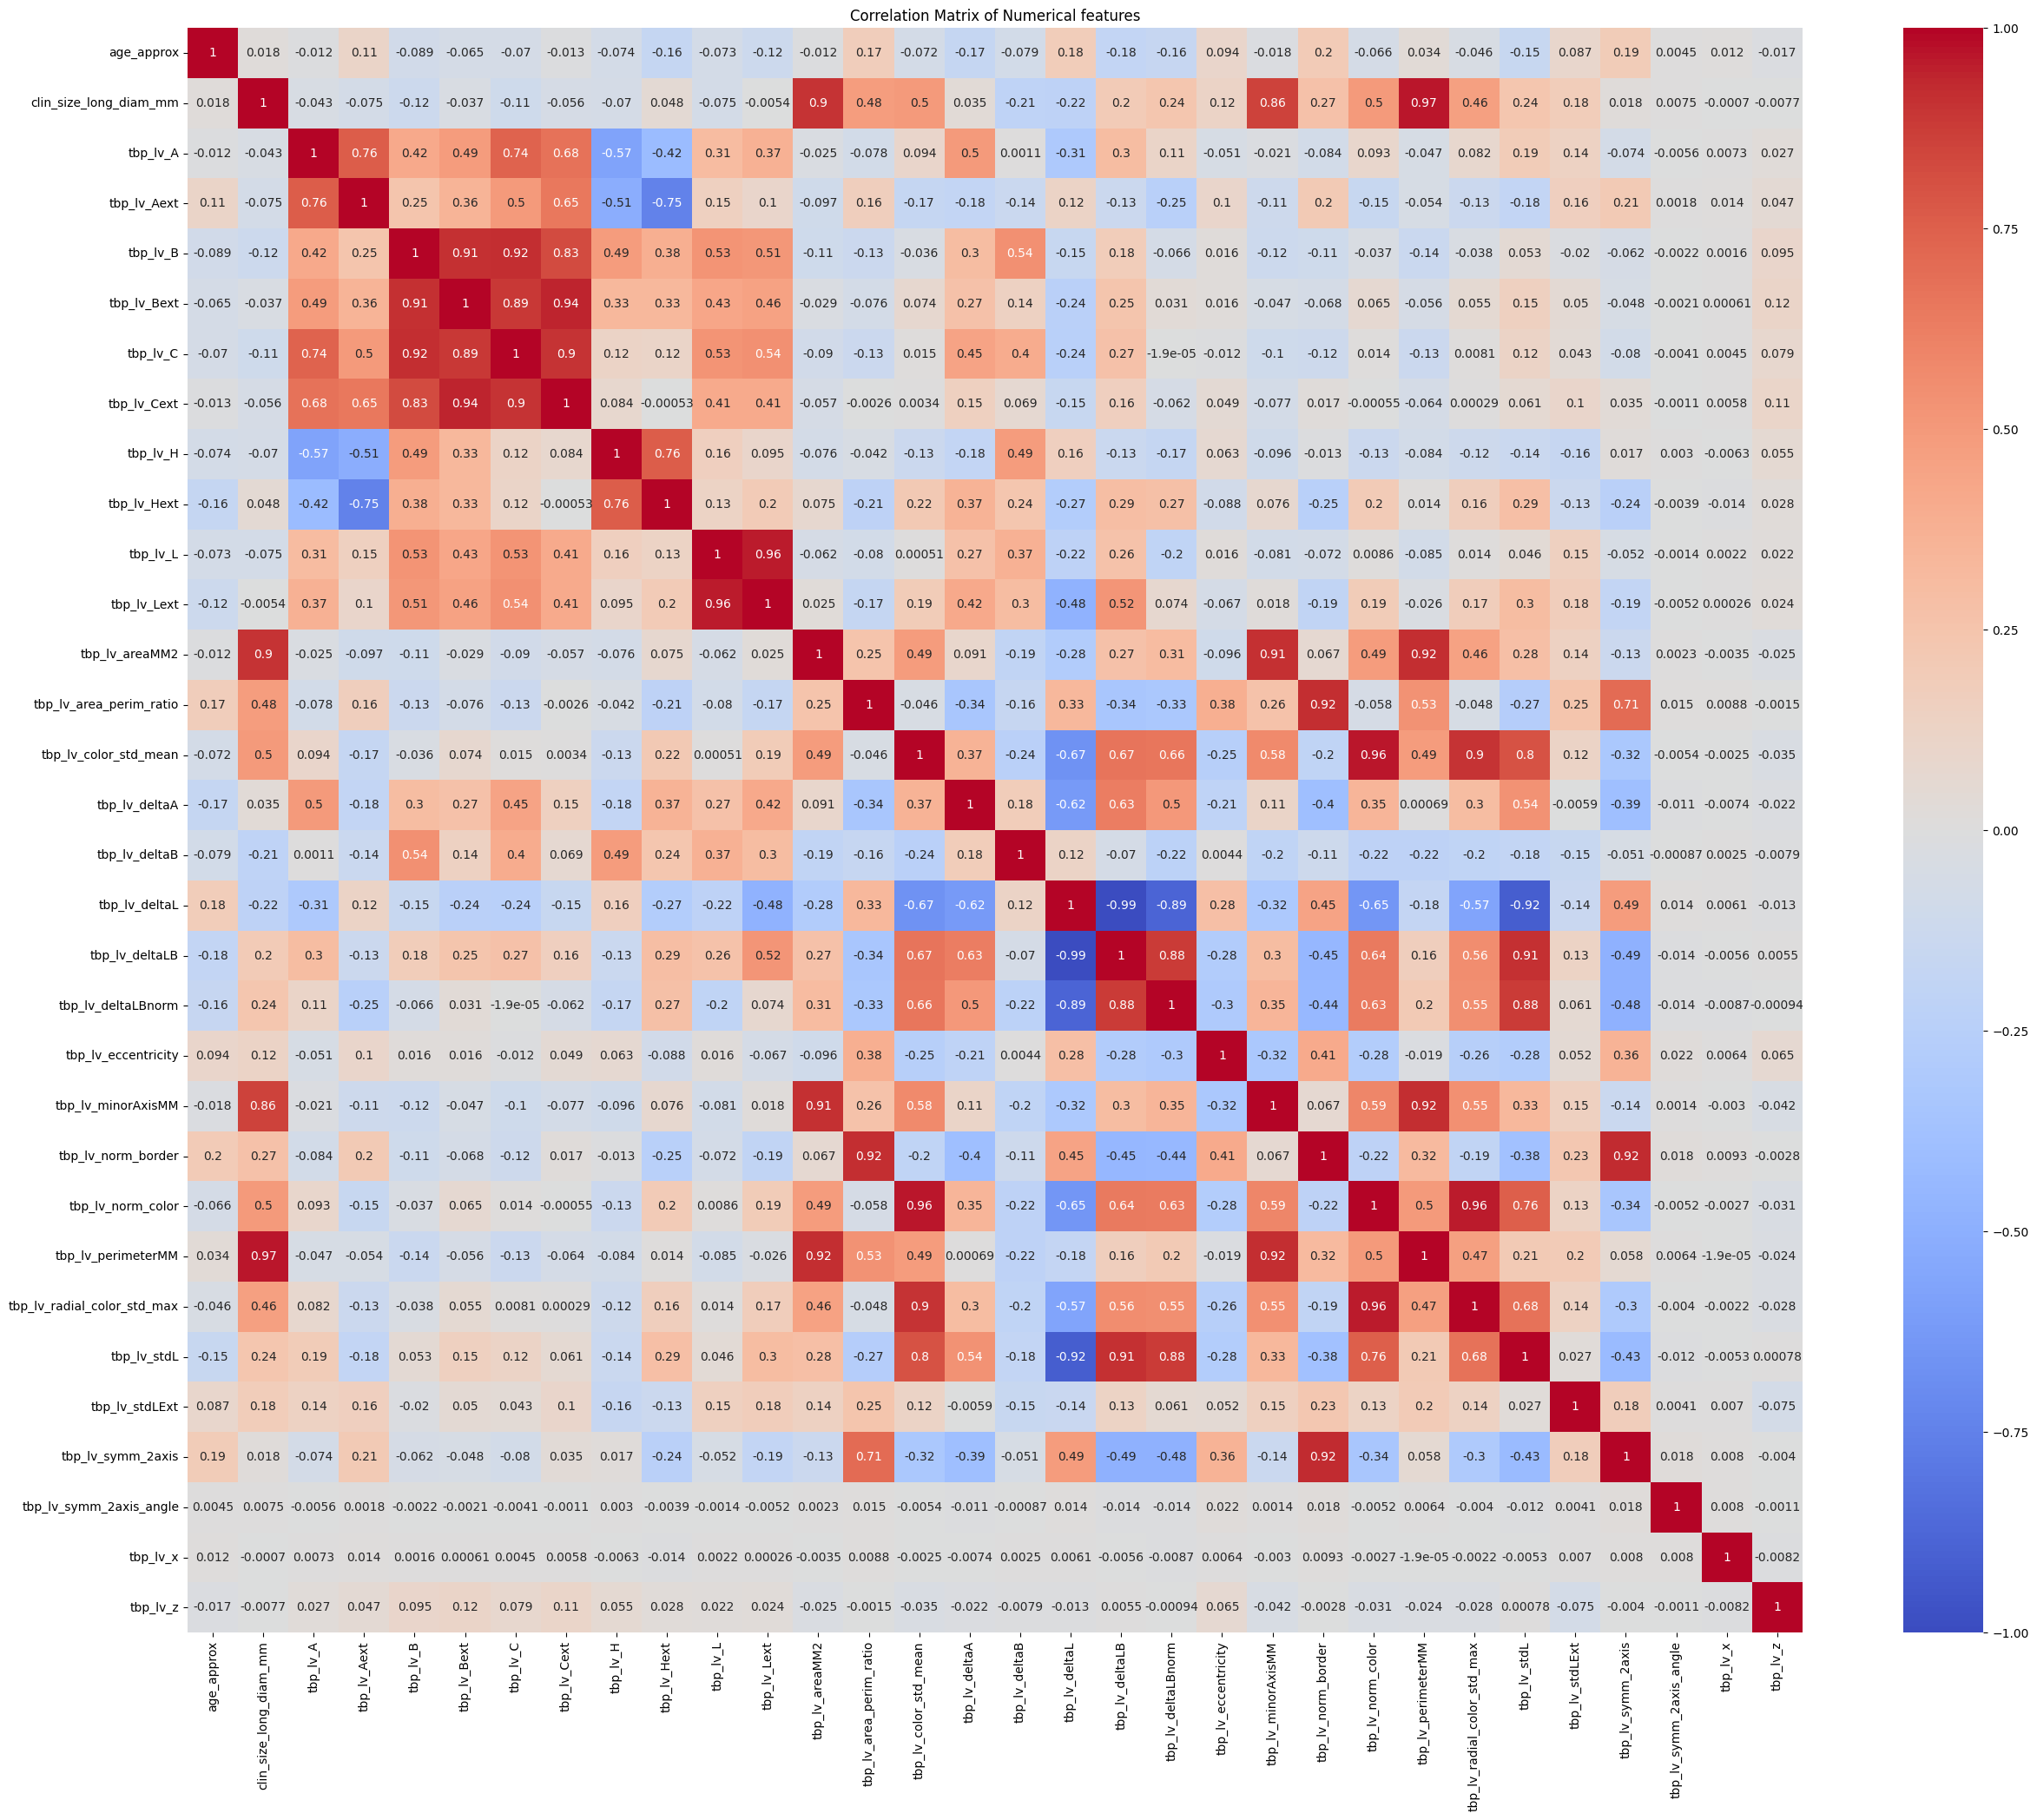

In [ ]:
correlation_matrix = X[numerical].corr()
plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical features')
plt.show()

In [ ]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(drop='first'), categorical)

    ]
)

In [ ]:
X_pre = preprocessor.fit_transform(X)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

In [ ]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
#Needed to convert X_train to dense Numpy array from sparse matrix
# X_train_arr = X_train.toarray()
# X_val_arr = X_val.toarray()
X_train_arr = X_train
X_val_arr = X_val

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_arr, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)


# X_train_tensor = torch.tensor(X_train_arr, dtype=torch.float32).to(device)
# X_val_tensor = torch.tensor(X_val_arr, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
class LogisticRegression(nn.Module):
  def __init__(self, n_features):
    super(LogisticRegression, self).__init__()
    self.linear1 = nn.Linear(n_features, 1)

  def forward(self, x):
    # y_pred = torch.sigmoid(self.linear1(x))
    y_pred = self.linear1(x)
    return y_pred

In [ ]:
n_features = X_train_tensor.shape[1]
model = LogisticRegression(n_features)

In [ ]:
class_weights = torch.tensor([0.001, 0.999])
lr = .01
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor ([3]))
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [ ]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train_tensor)
  loss = criterion(y_pred, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  if (epoch+1)%100 == 0:
    print(f'epoch: {epoch+1}, loss: {loss.item():.2f}')


epoch: 100, loss: 0.80
epoch: 200, loss: 0.77
epoch: 300, loss: 0.76
epoch: 400, loss: 0.75
epoch: 500, loss: 0.74
epoch: 600, loss: 0.73
epoch: 700, loss: 0.73
epoch: 800, loss: 0.72
epoch: 900, loss: 0.72
epoch: 1000, loss: 0.72


In [ ]:
model.eval()
with torch.inference_mode():
  y_pred = model(X_val_tensor)
  y_pred_cls = y_pred.round()
  acc = y_pred_cls.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])
  print(f'accuracy: {acc:.2f}')

accuracy: 0.29


In [ ]:
# Assuming the model is already trained
feature_importance = model.linear1.weight.detach().numpy().flatten()

# Display the importance of each feature
for idx, importance in enumerate(feature_importance):
    print(f'Feature {idx + 1}: {importance}')


Feature 1: 0.12403029948472977
Feature 2: 0.013134066946804523
Feature 3: 0.15689554810523987
Feature 4: 0.24045929312705994
Feature 5: -0.32715827226638794
Feature 6: -0.10934142768383026
Feature 7: -0.07144837081432343
Feature 8: 0.11231455951929092
Feature 9: -0.33525362610816956
Feature 10: -0.19106243550777435
Feature 11: 0.22381266951560974
Feature 12: 0.14951092004776
Feature 13: 0.3226836621761322
Feature 14: -0.28856030106544495
Feature 15: 0.033069029450416565
Feature 16: 0.0625016838312149
Feature 17: -0.40050098299980164
Feature 18: 0.1567090004682541
Feature 19: -0.06493102759122849
Feature 20: -0.013850560411810875
Feature 21: -0.24738706648349762
Feature 22: 0.022989220917224884
Feature 23: -0.18335874378681183
Feature 24: -0.08274157345294952
Feature 25: -0.02353920228779316
Feature 26: 0.18886174261569977
Feature 27: 0.24410104751586914
Feature 28: 0.2744331955909729
Feature 29: 0.29772111773490906
Feature 30: 0.03305203467607498
Feature 31: -0.04326329380273819
Featur

In [ ]:
import pandas as pd

# Assuming the model is already trained
feature_importance = model.linear1.weight.detach().numpy().flatten()

# Assuming you have feature names available
# For example, if X is your original DataFrame:
feature_names = n_features

# Create a DataFrame with feature names and their importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': feature_importance
})

# Sort the DataFrame by the weight in descending order (absolute values to consider magnitude)
importance_df = importance_df.reindex(importance_df.Weight.abs().sort_values(ascending=False).index)

# Display the sorted DataFrame
importance_df


,Feature,Weight
16,66,-0.400501
8,66,-0.335254
4,66,-0.327158
12,66,0.322684
28,66,0.297721
...,...,...
51,66,-0.014259
19,66,-0.013851
52,66,0.013463
1,66,0.013134


In [ ]:
# prompt: make a bar chart of importance_df, showing relative importances of features

import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Weight'])
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Feature Importance')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming the model is already trained
feature_importance = model.linear1.weight.detach().numpy().flatten()

# Assuming you don't have specific feature names and are just using indices
feature_indices = range(1, len(feature_importance) + 1)

# Create a DataFrame with feature indices and their importance
importance_df = pd.DataFrame({
    'Feature': feature_indices,
    'Weight': feature_importance
})

# Sort the DataFrame by the weight in descending order
importance_df = importance_df.reindex(importance_df.Weight.abs().sort_values(ascending=False).index)

# Display the sorted DataFrame
importance_df

,Feature,Weight
16,17,-0.400501
8,9,-0.335254
4,5,-0.327158
12,13,0.322684
28,29,0.297721
...,...,...
51,52,-0.014259
19,20,-0.013851
52,53,0.013463
1,2,0.013134


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have your validation data and model
# Make predictions (assuming you have a binary classification problem)
y_val_pred = (model(X_val_tensor) > 0.5).float()

# Convert predictions and labels to numpy arrays for sklearn
y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val_tensor.detach().numpy()


In [ ]:
# Generate classification report
report = classification_report(y_val_true, y_val_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

# Convert the classification report to a DataFrame for easier viewing
report_df = pd.DataFrame(report).transpose()

# Display the classification report
print(report_df)


              precision    recall  f1-score       support
Class 0        0.999891  0.686503  0.814078  80138.000000
Class 1        0.002699  0.918919  0.005383     74.000000
accuracy       0.686718  0.686718  0.686718      0.686718
macro avg      0.501295  0.802711  0.409731  80212.000000
weighted avg   0.998971  0.686718  0.813332  80212.000000


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 9999})
rf_model.fit(X_resampled, y_resampled)

y_val_pred = rf_model.predict(X_val)
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])
print(report)


              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     80138
     Class 1       0.09      0.01      0.02        74

    accuracy                           1.00     80212
   macro avg       0.54      0.51      0.51     80212
weighted avg       1.00      1.00      1.00     80212



In [ ]:
y_val_pred = rf_model.predict(X_val)
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     80138
     Class 1       0.09      0.01      0.02        74

    accuracy                           1.00     80212
   macro avg       0.54      0.51      0.51     80212
weighted avg       1.00      1.00      1.00     80212



In [ ]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

dtrain_resampled = xgb.DMatrix(X_resampled, label=y_resampled)
dval = xgb.DMatrix(X_val, label=y_val)  # Validation data remains unchanged


NameError: name 'xgb' is not defined

In [ ]:
import xgboost as xgb


# Set up parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Evaluation metric for binary classification
    'scale_pos_weight': 1000,         # Adjust this based on the imbalance ratio (positive to negative class)
    'eta': 0.1,                      # Learning rate
    'max_depth': 5,                  # Maximum depth of a tree
    'subsample': 0.8,                # Subsample ratio of the training instance
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'random_state': 42               # For reproducibility
}

# Train the model
model = xgb.train(
    params,
    dtrain_resampled,
    num_boost_round=100,
    evals=[(dval, 'validation')],
    early_stopping_rounds=100,
    verbose_eval=True
)


# Make predictions on the validation set
y_val_pred_proba = model.predict(dval)
y_val_pred = (y_val_pred_proba > 0.4).astype(int)  # Convert probabilities to binary predictions


In [ ]:
# Generate and print the classification report
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])
print(report)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))